## Installing Libraries

In [ ]:
!pip install vitaldb neurokit2


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.4/708.4 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 58.2 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 wh

# Import Libraries

In [ ]:
import requests
import pandas as pd
import vitaldb
import io
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
import neurokit2 as nk

import warnings
warnings.filterwarnings('ignore')


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# User-Defined Parameters

In [ ]:
RAWDATAPATH = 'drive/MyDrive/2025_PPG_GLUC/Data/Raw Data/'

In [ ]:
os.listdir(RAWDATAPATH)

['clinical_parameters.csv',
 'DataSource.txt',
 'lab_parameters.csv',
 'track_names.csv',
 'VitalDB',
 'lab_data.csv',
 'clinical_data.csv']

# Download and Save Data (One-Time)

There are discrepancies in clinical data (at least in age) being found between url version and flatfile version

Use url version which is close to what paper uses

In [ ]:
# # Download Lab Data
# labs_url = "https://api.vitaldb.net/labs"
# labs_response = requests.get(labs_url)

# if labs_response.status_code != 200:
#     print(f"Failed to load labs data: {labs_response.status_code}")
# else:
#     labs_data = pd.read_csv(io.StringIO(labs_response.text))
#     print(f"Total labs measurements: {len(labs_data)}")
#     labs_data.to_csv(RAWDATAPATH + 'lab_data.csv')

# # Download Clinical Data
# clinical_url = "https://api.vitaldb.net/cases"
# clinical_response = requests.get(clinical_url)

# if clinical_response.status_code != 200:
#     print(f"Failed to load clinical data: {clinical_response.status_code}")
# else:
#     clinical_data = pd.read_csv(io.StringIO(clinical_response.text))
#     print(f"Clinical data loaded: {len(clinical_data)} cases")
#     clinical_data.to_csv(RAWDATAPATH + 'clinical_data.csv')

# Load Data

In [ ]:
labs_data = pd.read_csv(RAWDATAPATH + 'lab_data.csv').drop(columns=['Unnamed: 0'])
clinical_data = pd.read_csv(RAWDATAPATH + 'clinical_data.csv').drop(columns=['Unnamed: 0'])

labs_data.shape, clinical_data.shape, clinical_data['caseid'].nunique()

((928448, 4), (6388, 74), 6388)

# Find Caseids with Glucose Reading

In [ ]:
glucose_data = labs_data[labs_data['name'] == 'gluc'].copy()
print(glucose_data.shape, glucose_data['caseid'].nunique())

# Glucose reading outside case time
print(glucose_data[glucose_data['dt']<0].shape[0]/glucose_data.shape[0])

(35358, 4) 5091
0.255218055319871


In [ ]:

# labs_url = "https://api.vitaldb.net/labs"
# labs_response = requests.get(labs_url)

# if labs_response.status_code != 200:
#     print(f"Failed to load labs data: {labs_response.status_code}")
# else:
#     labs_data = pd.read_csv(io.StringIO(labs_response.text))
#     print(f"Total labs measurements: {len(labs_data)}")

#     glucose_data = labs_data[labs_data['name'] == 'gluc'].copy() #filtering for gluc measurements
#     print(f"Glucose measurements: {len(glucose_data)}")

#     glucose_cases = glucose_data['caseid'].unique() #unique caseids with gluc measurements
#     print(f"Cases with glucose readings: {len(glucose_cases)}")

# Filter Glucose Reading by Case Timings

Filters applied:
* dt >= casestart
* dt <= caseend

In [ ]:
glucose_with_timing = pd.merge(glucose_data,
                               clinical_data[['caseid', 'casestart', 'caseend']],
                               on='caseid', how='left')
print(clinical_data.shape, glucose_with_timing.shape)
print(clinical_data[clinical_data['casestart'].isna()].shape,
      clinical_data[clinical_data['caseend'].isna()].shape,
      glucose_with_timing[glucose_with_timing['dt'].isna()].shape,
      glucose_with_timing['caseid'].nunique())

# Valid time
valid_timing = glucose_with_timing[
        (glucose_with_timing['dt'] >= glucose_with_timing['casestart']) &
        (glucose_with_timing['dt'] <= glucose_with_timing['caseend'])
    ]
print(valid_timing.shape, valid_timing['caseid'].nunique())

(6388, 74) (35358, 6)
(0, 74) (0, 74) (0, 6) 5091
(8847, 6) 3297


In [ ]:
glucose_with_timing.head()

,caseid,dt,name,result,casestart,caseend
0,1,3060,gluc,154.0,0,11542
1,1,4628,gluc,182.0,0,11542
2,1,12614,gluc,198.0,0,11542
3,1,8921,gluc,210.0,0,11542
4,2,5857898,gluc,114.0,0,15741


In [ ]:
# clinical_url = "https://api.vitaldb.net/cases"
# clinical_response = requests.get(clinical_url)

# if clinical_response.status_code != 200:
#     print(f"Failed to load clinical data: {clinical_response.status_code}")
# else:
#     clinical_data = pd.read_csv(io.StringIO(clinical_response.text))
#     print(f"Clinical data loaded: {len(clinical_data)} cases")

#     clinical_glucose_data = clinical_data['preop_gluc']

#     # Merge glucose data with clinical timing info
#     glucose_with_timing = glucose_data.merge(
#         clinical_data[['caseid', 'casestart', 'caseend']],
#         on='caseid',
#         how='left'
#     )

#     print(f"Glucose readings with timing info: {len(glucose_with_timing)}")
#     print(f"Missing timing info: {glucose_with_timing[['casestart', 'caseend']].isnull().sum()}")

#     # Filter for readings within case boundaries (casestart to caseend)
#     valid_timing = glucose_with_timing[
#         (glucose_with_timing['casestart'].notna()) &
#         (glucose_with_timing['caseend'].notna()) &
#         (glucose_with_timing['dt'] >= glucose_with_timing['casestart']) &
#         (glucose_with_timing['dt'] <= glucose_with_timing['caseend'])
#     ]

#     print(f"Glucose readings within case timing: {len(valid_timing)}")
#     print(f"Cases with valid glucose timing: {len(valid_timing['caseid'].unique())}")

#     # Show timing statistics
#     print(f"Average case duration: {(valid_timing['caseend'] - valid_timing['casestart']).mean()/3600:.1f} hours")
#     print(f"Glucose readings per case (avg): {len(valid_timing)/len(valid_timing['caseid'].unique()):.1f}")


# Summary Statistics of Variables

## Before Preprocessing

In [ ]:
def create_glucose_summary_table(clinical_data, labs_data):
    """
    Create Table 1 summary statistics for glucose data variables only
    """
    print("=== SUMMARY STATISTICS TABLE (BGL, Age, Sex, BMI) ===\n")

    # Define your cohorts clearly
    clinical_glucose_cohort = clinical_data[clinical_data['preop_gluc'].notna()].copy()
    bgl_data = labs_data[labs_data['name']=='gluc']['result'].dropna()

    # Create list to store all statistics
    stats_list = []

    # BGL Statistics
    stats_list.append({
        'Variable': 'BGL (mg/dL)',
        'n': len(bgl_data),
        'Mean': bgl_data.mean(),
        'Std': bgl_data.std(),
        'Min': bgl_data.min(),
        'Max': bgl_data.max()
    })

    # Age Statistics
    if 'age' in clinical_glucose_cohort.columns:
        age_data = clinical_glucose_cohort['age'].dropna()
        stats_list.append({
            'Variable': 'Age (years)',
            'n': len(age_data),
            'Mean': age_data.mean(),
            'Std': age_data.std(),
            'Min': age_data.min(),
            'Max': age_data.max()
        })

    # Sex Statistics
    sex_binary = (clinical_glucose_cohort['sex'] == 'M').astype(int)
    male_count = sex_binary.sum()
    stats_list.append({
        'Variable': 'Sex (Male)',
        'n': len(sex_binary),
        'Mean': sex_binary.mean(),
        'Std': sex_binary.std(),
        'Min': 0,
        'Max': 1,
        'Count': male_count,
        'Percentage': sex_binary.mean() * 100
    })

    # BMI Statistics
    if 'bmi' in clinical_glucose_cohort.columns:
        bmi_data = clinical_glucose_cohort['bmi'].dropna()
        stats_list.append({
            'Variable': 'BMI (kg/m²)',
            'n': len(bmi_data),
            'Mean': bmi_data.mean(),
            'Std': bmi_data.std(),
            'Min': bmi_data.min(),
            'Max': bmi_data.max()
        })

    # Convert to DataFrame
    summary_df = pd.DataFrame(stats_list)

    # Format the display columns
    summary_df['Mean ± SD'] = summary_df.apply(
        lambda row: f"{row['Mean']:.2f} ± {row['Std']:.2f}"
        if row['Variable'] != 'Sex (Male)'
        else f"{row['Count']:.0f} ({row['Percentage']:.1f}%)",
        axis=1
    )

    summary_df['Range'] = summary_df.apply(
        lambda row: f"{row['Min']:.1f} - {row['Max']:.1f}",
        axis=1
    )

    # Select display columns
    display_df = summary_df[['Variable', 'n', 'Mean ± SD', 'Range']]

    print(display_df.to_string(index=False))
    display_df.to_csv('table1_glucose_summary.csv', index=False)

    return summary_df

In [ ]:
summary_df = create_glucose_summary_table(clinical_data, labs_data)

=== SUMMARY STATISTICS TABLE (BGL, Age, Sex, BMI) ===

   Variable     n      Mean ± SD         Range
BGL (mg/dL) 35358 134.78 ± 52.10 12.0 - 1211.0
Age (years)  6010  57.51 ± 14.90    0.3 - 94.0
 Sex (Male)  6010   3035 (50.5%)     0.0 - 1.0
BMI (kg/m²)  6010   23.29 ± 3.63   11.3 - 43.2


## After Preprocessing

In [ ]:
summary_df_after = create_glucose_summary_table(
    clinical_data[clinical_data['caseid'].isin(valid_timing['caseid'])],
    valid_timing.drop(columns=['casestart', 'caseend']))

# summary_df_after = create_glucose_summary_table(
#     clinical_data[clinical_data['caseid'].isin(valid_timing['caseid'])],
#     labs_data[labs_data['caseid'].isin(valid_timing['caseid'])])

=== SUMMARY STATISTICS TABLE (BGL, Age, Sex, BMI) ===

   Variable    n      Mean ± SD        Range
BGL (mg/dL) 8847 122.69 ± 37.30 12.0 - 483.0
Age (years) 3054  58.61 ± 15.07   0.3 - 94.0
 Sex (Male) 3054   1701 (55.7%)    0.0 - 1.0
BMI (kg/m²) 3054   23.06 ± 3.59  11.5 - 43.2


# PPG Temporal Alignment


*   Load PPG data from .npy files by case ID
*   Extract 16-minute windows
*   Temporal Alignment using timestamps

##    Temporal Alignment Calculated Using:
* `time_offset = glucose_time - case_start` - Time of glucose measurement relative to case start (in seconds)
* `center_sample = int(time_offset * sampling_rate)` - Exact sample index where glucose was measured
* `half_window = window_samples // 2` - Half of 16-minute window = 48,000 samples (8 minutes)
* `start_idx = center_sample - half_window` - Start of window (8 minutes before glucose measurement)
* `end_idx = center_sample + half_window` - End of window (8 minutes after glucose measurement)
* `ppg_window = ppg_data[start_idx:end_idx]` - Extract 96,000 samples (16 minutes at 100 Hz)

## Which cases are removed / avoided?:
* Any case that the glucose reading is not within the case start / case end is not used
* Any case that has the glucose reading too close to the case start / case end where it is not able to extract the full 16 minute window
* Any case that has missing PPG data
* Any case that has misisng case timing information

## [Remove] How quality_score is calculatede:
* We base the quality score off 3 metrics:
* `Signal to Noise Ratio (SNR) * Weight + Peak Regularity * Weight + Plausible Heart Rate * Weight`
* SNR: Measures variance in PPG signal / approximated noise
* Peak Regularity: Calculates 1 - coefficient of variation
* Heart Rate: If HR BPM is within 30 to 180 BPM, it is set to binary 1, else 0

## [Remove] NeuroKit2 `ppg_process` function
* Uses these functions `ppg_clean` `ppg_peaks` `ppg_rate`
* Applies Butterworth bandpass filter (0.5-8 Hz by default)
* Removes baseline drift (< 0.5 Hz) - breathing, movement
* Removes high-frequency noise (> 8 Hz) - electrical interference
* Centers the signal around zero
* Calculates peaks


In [ ]:
# Sort caseid
valid_timing = valid_timing.sort_values(by='caseid')

# Parameters
output_path = 'drive/MyDrive/2025_PPG_GLUC/Data/Processed Data/BW_ppg_16min_windows/'
sampling_rate = 100
window_duration = 16 * 60  # seconds
window_samples = window_duration * sampling_rate
# caseid_holder = int(-1)

# for index, row in tqdm(valid_timing.iterrows()):
#     caseid = row['caseid']
#     glucose_time = row['dt']
#     case_start = row['casestart']
#     filename = f"case_{caseid}_time_{glucose_time}_cleaned.npy"

#     # Skip if already exist
#     if os.path.exists(output_path + filename):
#         continue

#     # Load Data
#     if caseid != caseid_holder:  # Reload
#         ppg_file = f"{RAWDATAPATH}VitalDB/Vital/vitaldb_PLETH_case_{caseid}.npy"
#         try:
#             ppg_data = np.load(ppg_file)
#             caseid_holder = caseid
#         except:
#             print(f'Error in loading vitaldb_PLETH_case_{caseid}.npy')
#             continue  # skip to next

#     # Extract window
#     time_offset = glucose_time - case_start # to calculate relative time to case start
#     center_sample = int(time_offset * sampling_rate) # to find the sampling index for gluc reading
#     half_window = window_samples // 2 # for the 8 minute window

#     start_idx = center_sample - half_window # start of window
#     end_idx = center_sample + half_window # end of window

#     if start_idx < 0 or end_idx >= len(ppg_data): # if ppg data out of the boundary, returns none
#         print(f'Error in extracting {caseid}: out of boundary')
#         continue
#     else: # Forward filling missing
#         cleaned_ppg_data = pd.Series(ppg_data[start_idx:end_idx].flatten()).ffill().values
#         np.save(output_path + filename, cleaned_ppg_data)

## Generate Meta Data

In [ ]:
# Recreate ppg_data_meta (Errors in previous version)

ppg_data_meta = pd.read_csv(output_path + 'BW_ppg_16min_metadata.csv')
# ppg_data_meta = pd.DataFrame({'Caseid':[], 'Gluc':[], 'Info':[]})

# Reduce repeated work
tmp_valid_timing = valid_timing.copy()
tmp_valid_timing['flag'] = tmp_valid_timing.apply(lambda x: str(x['caseid']) + '_' + str(x['dt']), axis=1)
tmp_ppg_data_meta = ppg_data_meta.copy()
tmp_ppg_data_meta['flag'] = tmp_ppg_data_meta.apply(lambda x: str(int(x['Caseid'])) + '_' + str(int(x['Gluc'])), axis=1)

for index, row in tqdm(tmp_valid_timing[~tmp_valid_timing['flag'].isin(
    tmp_ppg_data_meta['flag'])].iterrows()):
# for index, row in tqdm(valid_timing.iterrows()):
    caseid = row['caseid']
    glucose_time = row['dt']
    case_start = row['casestart']
    filename = f"case_{caseid}_time_{glucose_time}_cleaned.npy"

    if ppg_data_meta[(ppg_data_meta['Caseid']==caseid) & (
        ppg_data_meta['Gluc']==glucose_time)].shape[0] == 0:
        # For caseid sequence failing to be extracted: Due to out of boundary
        if not os.path.exists(output_path + filename):
            ppg_data_meta = pd.concat([ppg_data_meta,
                pd.DataFrame({'Caseid':[caseid], 'Gluc': [glucose_time],
                              'Info': ['Out of boundary']})],
                ignore_index=True)
        else: # For caseid sequence succesfully extracted
            # Extract window
            time_offset = glucose_time - case_start # to calculate relative time to case start
            center_sample = int(time_offset * sampling_rate) # to find the sampling index for gluc reading
            half_window = window_samples // 2 # for the 8 minute window

            start_idx = center_sample - half_window # start of window
            end_idx = center_sample + half_window # end of window

            # Load data
            ppg_file = f"{RAWDATAPATH}VitalDB/Vital/vitaldb_PLETH_case_{caseid}.npy"
            ppg_data = np.load(ppg_file) # raw data
            ppg_data = ppg_data[start_idx:end_idx]
            cleaned_ppg_data = np.load(output_path + filename)

            # Note down the missing values that being forward filled
            original_nan = sum([1 for i in ppg_data.flatten() if np.isnan(i)])
            filled_nan = sum([1 for i in cleaned_ppg_data.flatten() if np.isnan(i)])
            ppg_data_meta = pd.concat([ppg_data_meta,
                pd.DataFrame({'Caseid':[caseid], 'Gluc': [glucose_time],
                              'Info': [f'Original missing: {original_nan}, After filling missing: {filled_nan}']})],
                ignore_index=True)

ppg_data_meta.to_csv(output_path + 'BW_ppg_16min_metadata.csv', index=False)
ppg_data_meta.head()

In [ ]:
ppg_data_meta.shape

## Edit and Analysis Aligned PPG

In [ ]:
ppg_data_meta['Caseid'].nunique()

In [ ]:
ppg_data_meta.head()

In [ ]:
ppg_data_meta[ppg_data_meta['Info'].str.contains('Original missing: 1390, After filling missing: 1390')]

In [ ]:
ppg_data_meta[(~ppg_data_meta['Info'].str.contains('After filling missing: 0')) & (
    ~ppg_data_meta['Info'].str.contains('Out of boundary'))]['Info'].value_counts()

,count
Info,
"Original missing: 96000, After filling missing: 96000",24
"Original missing: 1390, After filling missing: 1390",1
"Original missing: 88287, After filling missing: 88287",1
"Original missing: 3351, After filling missing: 3351",1
"Original missing: 12597, After filling missing: 12597",1
"Original missing: 43633, After filling missing: 43633",1
"Original missing: 2331, After filling missing: 2331",1
"Original missing: 59757, After filling missing: 59757",1
"Original missing: 83867, After filling missing: 83867",1


## Why Forward Filling not work for Some?

In [ ]:
ppg_data_meta[ppg_data_meta['Info'].str.contains('45091')]

,Caseid,Gluc,Info
7917,5750.0,19957.0,"Original missing: 45091, After filling missing..."


In [ ]:
ppg_file = f"drive/MyDrive/2025_PPG_GLUC/Data/Processed Data/BW_ppg_16min_windows/case_{5750}_time_{19957}_cleaned.npy"
ppg_data = np.load(ppg_file)

len(ppg_data), sum([1 for i in ppg_data.flatten()[:45092] if np.isnan(i)])

(96000, 45091)

In [ ]:
# # ============================================================================
# # NEUROKIT2 PPG PROCESSOR
# # ============================================================================

# class NeuroKit2PPGProcessor:
#     def __init__(self, ppg_data_path, sampling_rate=100):
#         self.ppg_path = Path(ppg_data_path)
#         self.sampling_rate = sampling_rate
#         self.window_duration = 16 * 60  # seconds
#         self.window_samples = self.window_duration * self.sampling_rate

#     def load_ppg(self, caseid):
#         ppg_file = self.ppg_path / f"vitaldb_PLETH_case_{caseid}.npy"
#         if ppg_file.exists():
#             try:
#                 return np.load(ppg_file)
#             except:
#                 return None
#         return None

#     def extract_window(self, ppg_data, glucose_time, case_start):
#         time_offset = glucose_time - case_start # to calculate relative time to case start
#         center_sample = int(time_offset * self.sampling_rate) # to find the sampling index for gluc reading
#         half_window = self.window_samples // 2 # for the 8 minute window

#         start_idx = center_sample - half_window # start of window
#         end_idx = center_sample + half_window # end of window

#         if start_idx < 0 or end_idx >= len(ppg_data): # if ppg data out of the boundary, returns none
#             return None

#         return ppg_data[start_idx:end_idx].flatten()

#     def preprocess_ppg(self, ppg_window):
#         import warnings
#         warnings.filterwarnings('ignore')

#         try:
#             # Forward fill missing values
#             ppg_clean = pd.Series(ppg_window).ffill().bfill().values

#             # NeuroKit2 processing
#             signals, info = nk.ppg_process(ppg_clean, sampling_rate=self.sampling_rate)

#             ppg_cleaned = signals['PPG_Clean'].values
#             peaks = info['PPG_Peaks']
#             quality_score = self._calculate_quality(ppg_cleaned, peaks)

#             return {
#                 'ppg_cleaned': ppg_cleaned,
#                 'peaks': peaks,
#                 'quality_score': quality_score,
#                 'success': True
#             }

#         except Exception as e:
#             return {
#                 'ppg_cleaned': None,
#                 'peaks': None,
#                 'quality_score': 0.0,
#                 'success': False,
#                 'error': str(e)
#             }

#     def _calculate_quality(self, ppg_signal, peaks):
#         if len(peaks) < 2:
#             return 0.0

#         # Signal-to-noise ratio
#         signal_power = np.var(ppg_signal)
#         noise_estimate = np.var(np.diff(ppg_signal))
#         snr = signal_power / (noise_estimate + 1e-10)

#         # Peak regularity
#         peak_intervals = np.diff(peaks)
#         if len(peak_intervals) > 1:
#             interval_std = np.std(peak_intervals)
#             interval_mean = np.mean(peak_intervals)
#             regularity = 1 - (interval_std / (interval_mean + 1e-10))
#         else:
#             regularity = 0.0

#         # Physiological range check (30-180 BPM)
#         heart_rate = 60 * self.sampling_rate / np.mean(peak_intervals) if len(peak_intervals) > 0 else 0
#         hr_valid = 1.0 if 30 <= heart_rate <= 180 else 0.0

#         quality = (0.4 * np.clip(snr / 10, 0, 1) +
#                    0.4 * np.clip(regularity, 0, 1) +
#                    0.2 * hr_valid)

#         return quality

#     def process_all(self, valid_timing_df, output_path, quality_threshold=0.3):
#         output_path = Path(output_path)
#         output_path.mkdir(parents=True, exist_ok=True)

#         processed_dir = output_path / 'ppg_16min_windows'
#         processed_dir.mkdir(exist_ok=True)

#         results = []
#         total_processed = 0
#         total_success = 0

#         for caseid, case_group in tqdm(valid_timing_df.groupby('caseid'), desc="Processing"):
#             ppg_data = self.load_ppg(caseid)

#             if ppg_data is None:
#                 continue

#             for idx, row in case_group.iterrows():
#                 ppg_window = self.extract_window(ppg_data, row['dt'], row['casestart'])

#                 if ppg_window is None:
#                     continue

#                 total_processed += 1

#                 result = self.preprocess_ppg(ppg_window)

#                 if result['success'] and result['quality_score'] >= quality_threshold:
#                     total_success += 1

#                     filename = f"case_{caseid}_time_{row['dt']}_cleaned.npy"
#                     np.save(processed_dir / filename, result['ppg_cleaned'])

#                     results.append({
#                         'caseid': caseid,
#                         'glucose_value': row['result'],
#                         'glucose_time': row['dt'],
#                         'quality_score': result['quality_score'],
#                         'num_peaks': len(result['peaks']),
#                         'filename': filename
#                     })

#         metadata_df = pd.DataFrame(results)
#         metadata_df.to_csv(output_path / 'ppg_16min_metadata.csv', index=False)

#         print(f"\n=== Processing Complete ===")
#         print(f"Total windows extracted: {total_processed}")
#         print(f"High-quality windows saved: {total_success}")
#         print(f"Success rate: {total_success/total_processed*100:.1f}%")
#         print(f"Mean quality score: {metadata_df['quality_score'].mean():.3f}")

#         return metadata_df

#     def visualize_sample(self, metadata_df, processed_dir, sample_idx=0, duration=10):
#         row = metadata_df.iloc[sample_idx]
#         ppg_cleaned = np.load(Path(processed_dir) / row['filename'])

#         samples = duration * self.sampling_rate
#         center = len(ppg_cleaned) // 2
#         start = center - samples // 2
#         end = start + samples

#         sample_ppg = ppg_cleaned[start:end]
#         time_axis = np.arange(len(sample_ppg)) / self.sampling_rate

#         plt.figure(figsize=(15, 5))
#         plt.plot(time_axis, sample_ppg, 'b-', linewidth=1)
#         plt.title(f"Cleaned PPG - Case {row['caseid']}, Glucose: {row['glucose_value']:.1f} mg/dL, Quality: {row['quality_score']:.2f}")
#         plt.xlabel('Time (seconds)')
#         plt.ylabel('PPG Amplitude')
#         plt.grid(True, alpha=0.3)
#         plt.tight_layout()
#         plt.show()

# # ============================================================================
# # EXECUTION
# # ============================================================================

# from google.colab import drive
# drive.mount('/content/drive')

# ppg_path = "/content/drive/MyDrive/2025_PPG_GLUC/Data/Raw Data/VitalDB/Vital"
# output_path = "/content/drive/MyDrive/2025_PPG_GLUC/Data/Processed Data"

# processor = NeuroKit2PPGProcessor(ppg_path)
# metadata = processor.process_all(valid_timing, output_path, quality_threshold=0.3)

# # Visualize sample
# processor.visualize_sample(
#     metadata,
#     output_path + '/ppg_16min_windows',
#     sample_idx=0
# )

# print("\n=== Quality Distribution ===")
# print(metadata['quality_score'].describe())

# Filter PPG

**Nyquist Sampling Theorem**: https://www.geeksforgeeks.org/electronics-engineering/nyquist-sampling-theorem/

To accurately capture a signal, your sampling frequency must be at least twice the highest frequency component in that signal.

Otherwise, it may have band aliasing, i.e. high-freq signal appears like low-freq signal, causing distortion

In [ ]:
# Parameters
input_path = 'drive/MyDrive/2025_PPG_GLUC/Data/Processed Data/BW_ppg_16min_windows/'
output_path2 = 'drive/MyDrive/2025_PPG_GLUC/Data/Processed Data/BW_ppg_16min_filtered/'
sampling_rate = 100
low_cut = 0.5
high_cut = 8
order = 3

# Check the remaining
tmp_ppg_data_meta = ppg_data_meta[(~ppg_data_meta['Info'].str.contains('Out of boundary')) & (
    ~ppg_data_meta['Info'].str.contains('After filling missing: 96000'))].copy()
tmp_ppg_data_meta['filename'] = tmp_ppg_data_meta.apply(
    lambda x: f"case_{int(x['Caseid'])}_time_{int(x['Gluc'])}_filtered.npy", axis=1)

for index, row in tqdm(tmp_ppg_data_meta[~tmp_ppg_data_meta['filename'].isin(
    os.listdir(output_path2))].iterrows()):
    if (row['Info'] == 'Out of boundary') | ('After filling missing: 96000' in row['Info']):
        continue
    else:
        caseid = int(row['Caseid'])
        glucose_time = int(row['Gluc'])
        ppg_file = f"{input_path}case_{caseid}_time_{glucose_time}_cleaned.npy"
        output_file = f"{output_path2}case_{caseid}_time_{glucose_time}_filtered.npy"
        try:
          ppg_data = np.load(ppg_file)
          ppg_filtered = nk.signal_filter(
              ppg_data,
              sampling_rate=sampling_rate,
              lowcut=low_cut,       # low cut frequency (Hz)
              highcut=high_cut,        # high cut frequency (Hz)
              method='butterworth',
              order=order
          )
          np.save(output_file, ppg_filtered)
        except:
          print(f'Error in loading {ppg_file}')


0it [00:00, ?it/s]


## Analyze Filtered Signal

In [ ]:
input_path = 'drive/MyDrive/2025_PPG_GLUC/Data/Processed Data/BW_ppg_16min_windows/'
output_path2 = 'drive/MyDrive/2025_PPG_GLUC/Data/Processed Data/BW_ppg_16min_filtered/'

In [ ]:
def plot_comparison(filename, input_path, output_path, start, end):
    filename_cleaned = f'{input_path}{filename}cleaned.npy'
    filename_filtered = f'{output_path}{filename}filtered.npy'

    # Load Data
    cleaned_data = np.load(filename_cleaned)
    filtered_data = np.load(filename_filtered)

    # Plot
    time_axis = np.arange(start, end)
    fig, axes = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

    # Raw signal
    axes[0].plot(time_axis, cleaned_data[start:end], 'b-', linewidth=0.8, alpha=0.7)
    axes[0].set_title(f'{filename}_cleaned', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Amplitude (Raw)', fontsize=10)
    axes[0].grid(True, alpha=0.3)

    # Filtered signal
    axes[1].plot(time_axis, filtered_data[start:end], 'g-', linewidth=0.8)
    axes[1].set_title(f'{filename}_FILTERED', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Time (seconds)', fontsize=10)
    axes[1].set_ylabel('Amplitude (Filtered)', fontsize=10)
    axes[1].grid(True, alpha=0.3)

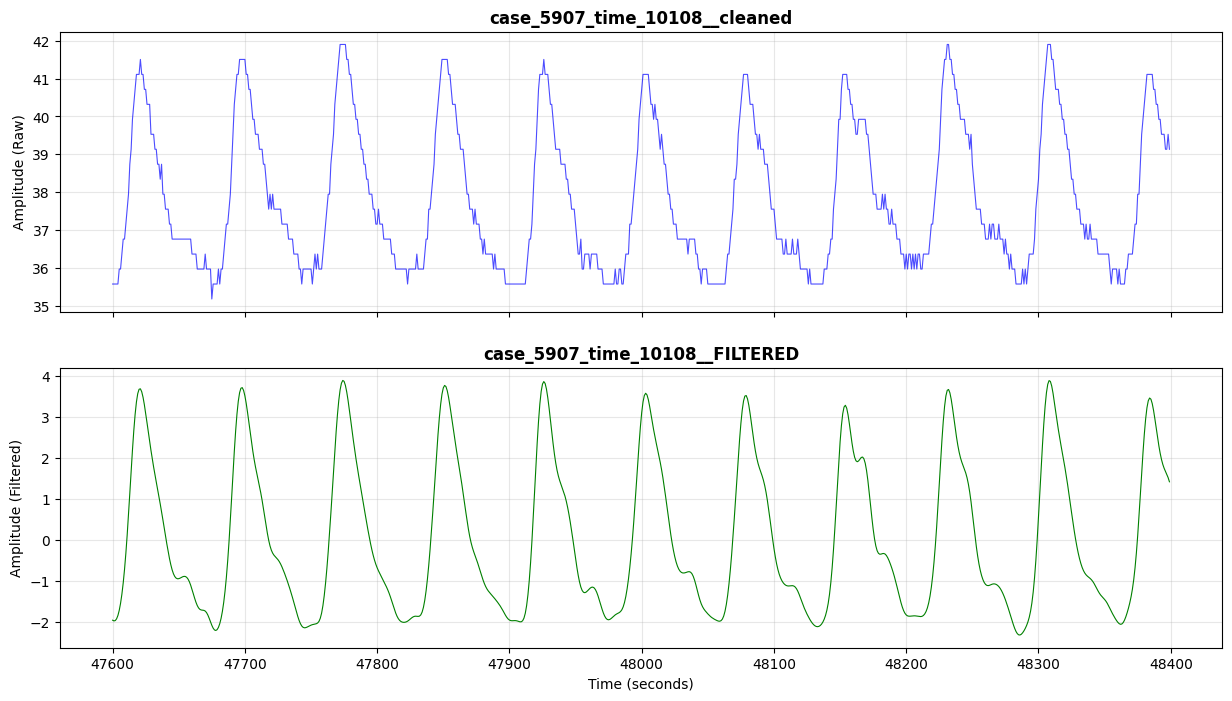

In [ ]:
plot_comparison(filename='case_5907_time_10108_',
                input_path = input_path,
                output_path = output_path2,
                start = 48000 - 400,
                end = 48000 + 400)

##

In [ ]:
# # ============================================================================
# # PPG FILTER COMPARISON - 5 SAMPLE CASES
# # ============================================================================


# class PPGFilterComparison:
#     def __init__(self, ppg_data_path, valid_timing_df, sampling_rate=100):
#         self.ppg_path = Path(ppg_data_path)
#         self.valid_timing = valid_timing_df
#         self.sampling_rate = sampling_rate
#         self.window_samples = 16 * 60 * sampling_rate

#     def load_ppg(self, caseid):
#         ppg_file = self.ppg_path / f"vitaldb_PLETH_case_{caseid}.npy"
#         if ppg_file.exists():
#             try:
#                 return np.load(ppg_file)
#             except:
#                 return None
#         return None

#     def extract_window(self, ppg_data, glucose_time, case_start):
#         time_offset = glucose_time - case_start
#         center_sample = int(time_offset * self.sampling_rate)
#         half_window = self.window_samples // 2

#         start_idx = center_sample - half_window
#         end_idx = center_sample + half_window

#         if start_idx < 0 or end_idx >= len(ppg_data):
#             return None

#         return ppg_data[start_idx:end_idx].flatten()

#     def get_sample_cases(self, n_samples=5):
#         samples = []

#         for caseid, case_group in self.valid_timing.groupby('caseid'):
#             ppg_data = self.load_ppg(caseid)

#             if ppg_data is None:
#                 continue

#             for _, row in case_group.iterrows():
#                 ppg_window = self.extract_window(ppg_data, row['dt'], row['casestart'])

#                 if ppg_window is not None and len(ppg_window) == self.window_samples:
#                     samples.append({
#                         'caseid': caseid,
#                         'glucose_value': row['result'],
#                         'ppg_raw': ppg_window,
#                         'glucose_time': row['dt']
#                     })

#                     if len(samples) >= n_samples:
#                         return samples

#         return samples

#     def compare_filtering(self, samples, output_path, plot_duration=15):
#         output_path = Path(output_path)
#         output_path.mkdir(parents=True, exist_ok=True)

#         plot_samples = plot_duration * self.sampling_rate

#         for idx, sample in enumerate(samples):
#             ppg_raw = sample['ppg_raw']

#             # Forward fill missing values
#             ppg_clean_input = pd.Series(ppg_raw).ffill().bfill().values

#             # Apply NeuroKit2 filtering
#             signals, info = nk.ppg_process(ppg_clean_input, sampling_rate=self.sampling_rate)
#             ppg_filtered = signals['PPG_Clean'].values
#             peaks = info['PPG_Peaks']

#             # Extract center portion for visualization
#             center = len(ppg_raw) // 2
#             start = center - plot_samples // 2
#             end = start + plot_samples

#             raw_segment = ppg_raw[start:end]
#             filtered_segment = ppg_filtered[start:end]
#             peaks_in_segment = peaks[(peaks >= start) & (peaks < end)] - start

#             time_axis = np.arange(len(raw_segment)) / self.sampling_rate

#             # Create comparison plot
#             fig, axes = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

#             # Raw signal
#             axes[0].plot(time_axis, raw_segment, 'b-', linewidth=0.8, alpha=0.7)
#             axes[0].set_title(f'Sample {idx+1} - RAW PPG Signal\n'
#                             f'Case {sample["caseid"]}, Glucose: {sample["glucose_value"]:.1f} mg/dL',
#                             fontsize=12, fontweight='bold')
#             axes[0].set_ylabel('Amplitude (Raw)', fontsize=10)
#             axes[0].grid(True, alpha=0.3)
#             axes[0].text(0.02, 0.98, f'Mean: {np.mean(raw_segment):.2f}\nStd: {np.std(raw_segment):.2f}',
#                         transform=axes[0].transAxes, verticalalignment='top',
#                         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

#             # Filtered signal with peaks
#             axes[1].plot(time_axis, filtered_segment, 'g-', linewidth=0.8)
#             axes[1].scatter(time_axis[peaks_in_segment], filtered_segment[peaks_in_segment],
#                           c='red', s=50, zorder=5, label=f'Peaks (n={len(peaks_in_segment)})')
#             axes[1].set_title('FILTERED PPG Signal (NeuroKit2: 0.5-8 Hz Butterworth + Peak Detection)',
#                             fontsize=12, fontweight='bold')
#             axes[1].set_xlabel('Time (seconds)', fontsize=10)
#             axes[1].set_ylabel('Amplitude (Filtered)', fontsize=10)
#             axes[1].grid(True, alpha=0.3)
#             axes[1].legend(loc='upper right')

#             # Calculate heart rate
#             if len(peaks_in_segment) > 1:
#                 peak_intervals = np.diff(peaks_in_segment) / self.sampling_rate
#                 hr = 60 / np.mean(peak_intervals)
#                 axes[1].text(0.02, 0.98,
#                            f'Mean: {np.mean(filtered_segment):.2f}\nStd: {np.std(filtered_segment):.2f}\nHR: {hr:.1f} BPM',
#                            transform=axes[1].transAxes, verticalalignment='top',
#                            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

#             plt.tight_layout()
#             plt.savefig(output_path / f'filter_comparison_sample_{idx+1}.png', dpi=150, bbox_inches='tight')
#             plt.show()

#             print(f"Sample {idx+1}: Case {sample['caseid']}, "
#                   f"Glucose {sample['glucose_value']:.1f} mg/dL, "
#                   f"Peaks detected: {len(peaks)}")

#         # Save sample metadata
#         metadata = pd.DataFrame([{
#             'sample_id': i+1,
#             'caseid': s['caseid'],
#             'glucose_value': s['glucose_value'],
#             'glucose_time': s['glucose_time']
#         } for i, s in enumerate(samples)])

#         metadata.to_csv(output_path / 'filter_comparison_metadata.csv', index=False)
#         print(f"\n✓ Saved {len(samples)} comparison plots to {output_path}")

# # ============================================================================
# # EXECUTION
# # ============================================================================

# ppg_path = "/content/drive/MyDrive/2025_PPG_GLUC/Data/Raw Data/VitalDB/Vital"
# output_path = "/content/drive/MyDrive/2025_PPG_GLUC/Data/Filter Comparison"

# comparator = PPGFilterComparison(ppg_path, valid_timing)

# print("Extracting 5 sample cases...")
# samples = comparator.get_sample_cases(n_samples=5)

# if len(samples) > 0:
#     print(f"Found {len(samples)} valid samples. Generating comparison plots...")
#     comparator.compare_filtering(samples, output_path, plot_duration=15)
# else:
#     print("No valid samples found!")


## Forward Filling doesn't work for some since they start with NaN

In [ ]:
file_path = "drive/MyDrive/2025_PPG_GLUC/Data/Processed Data/BW_ppg_16min_windows/case_241_time_19878_cleaned.npy"
data = np.load(file_path)
print(f"shape: {data.shape}")
print(f"first 100: \n {data[:100]}")

shape: (96000,)
first 100: 
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
